In [17]:
%load_ext autoreload
%autoreload 2

import os
import sys
import time
import random
import pandas as pd
import yaml

from argparse import Namespace

import numpy as np
import networkx as nx
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

root_dir = os.path.dirname(
        os.path.dirname(os.path.realpath(".")))

sys.path.append(root_dir)


import logging

from rl_envs_forge.envs.grid_world.grid_world import GridWorld
from common.src.distribution_src import ( 
                                         make_env, 
                                        randomize_walls_positions, 
                                        generate_train_test_split_with_valid_path,
                                        run_distribution_correction_experiment,
                                        compute_validation_bellmans_error,
                                        setup_dqn_agent
                                        )
from common.src.simple_dqn_agent import AgentDQN
from scipy.stats import entropy


from common.src.experiment_utils import (
    setup_logger,
    namespace_to_dict,
)

from common.src.distribution_src import run_dqn_distribution_correction_experiment


from argparse import Namespace

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[(2, 0), (1, 2)]


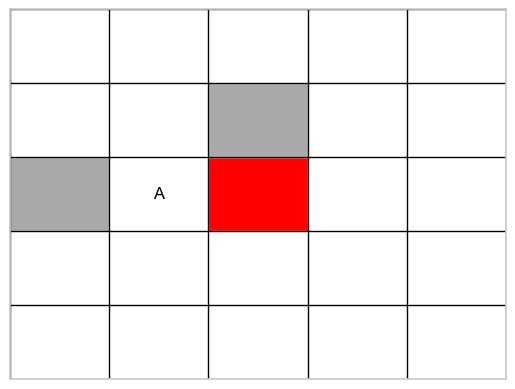

In [18]:
terminal_states = {(2, 2): 1}
start_state = (2, 1)
rows = 5
cols = 5
seed = 2

# random_walls = randomize_walls_positions(rows, cols, start_state, terminal_states, 0.2, seed=seed)
random_walls = [(2, 0), (1, 2)]
print(random_walls)
env = make_env(
    rows,
    cols,
    start_state=start_state,
    p_success=1,
    terminal_states=terminal_states,
    seed=seed,
    walls=random_walls,
)
env.render()

In [19]:
def get_observation_space_shape(observation_space):
    """Extract a shape-like tuple from a tuple of discrete spaces."""
    return tuple(space.n for space in observation_space.spaces)

In [20]:
env.observation_space

Tuple(Discrete(5), Discrete(5))

In [21]:
env.state

(2, 1)

In [22]:
def state_to_matrix(state, env):
    import numpy as np

    # Extract the environment size from walls and terminal states
    max_rows = env.rows
    max_cols = env.cols

    # Create the matrix
    matrix = np.zeros((max_rows, max_cols), dtype=int)

    # Mark walls in the matrix
    for wall in env.walls:
        matrix[wall[0], wall[1]] = 1  # Use 1 to indicate walls

    # Mark terminal states in the matrix
    for terminal, value in env.terminal_states.items():
        matrix[terminal[0], terminal[1]] = 2

    pos = state
    matrix[pos[0], pos[1]] = 3  # Use 3 to indicate the agent's position

    return matrix


state_to_matrix(env.state, env)

array([[0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 3, 2, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [23]:
state_shape = get_observation_space_shape(env.observation_space)
state_shape

(5, 5)

In [24]:
# env.mdp

In [25]:
# ts = next(iter(terminal_states))

# for trial in range(100000):
#     random_walls = randomize_walls_positions(rows, cols, start_state, terminal_states, 0.2, seed=trial)

#     if (start_state in random_walls) or (ts in random_walls):
#         raise ValueError("start state or terminal state in walls")

In [26]:
transitions_list = [(key[0], key[1], *value[0]) for key, value in env.mdp.items()]

transitions_train, transitions_val = generate_train_test_split_with_valid_path(
    transitions_list=transitions_list,
    start_state=start_state,
    terminal_states=terminal_states,
)

In [27]:
### Load up a config

file_path = r"D:\Work\repos\phd-research\experiments\dqn\results\2024Jun10-002258_configs\0000_algorithm_default\1\cfg.yaml"

# Open the YAML file and load its content into a dictionary
with open(file_path, "r") as file:
    data = yaml.safe_load(file)

opts = Namespace(**data)

logger = setup_logger(opts.full_title)

opts.seed = random.randint(0, 2**32 - 1) if opts.seed is None else opts.seed
opts_dict = namespace_to_dict(opts)
# opts_dict = vars(opts)

opts_dict

{'agent_params': {'agent': 'AgentDQN',
  'args_': {'batch_size': 32,
   'epsilon': {'decay': 5000, 'end': 0.01, 'start': 1.0},
   'gamma': 0.9,
   'loss_fcn': 'mse_loss',
   'replay_start_size': 50,
   'target_model_update_freq': 40,
   'train_step_cnt': 500,
   'training_freq': 4,
   'validation_enabled': False,
   'validation_epsilon': 0.001,
   'validation_step_cnt': 250}},
 'algorithm': 'default',
 'cfg_id': 0,
 'cols': 10,
 'experiment': 'experiment_distributions',
 'experiment_arguments': {'algorithm': 'default'},
 'full_title': '2024Jun10-002258_configs_algorithm=default',
 'neural_fit_mode': 'max',
 'num_steps': 40000,
 'optim': {'args_': {'eps': 0.0003125, 'lr': 0.1}, 'name': 'Adam'},
 'out_dir': '.\\results\\2024Jun10-002258_configs\\0000_algorithm_default\\1',
 'p_success': 1,
 'replay_buffer': {'action_dim': 1, 'max_size': 1000, 'n_step': 0},
 'rows': 10,
 'run_id': 1,
 'seed': 539462332,
 'start_state': (1, 1),
 'terminal_states': {(8, 8): 1.0},
 'title': 'algorithm=defaul

In [28]:
opts

Namespace(agent_params={'agent': 'AgentDQN', 'args_': {'batch_size': 32, 'epsilon': {'decay': 5000, 'end': 0.01, 'start': 1.0}, 'gamma': 0.9, 'loss_fcn': 'mse_loss', 'replay_start_size': 50, 'target_model_update_freq': 40, 'train_step_cnt': 500, 'training_freq': 4, 'validation_enabled': False, 'validation_epsilon': 0.001, 'validation_step_cnt': 250}}, algorithm='default', cfg_id=0, cols=10, experiment='experiment_distributions', experiment_arguments={'algorithm': 'default'}, full_title='2024Jun10-002258_configs_algorithm=default', neural_fit_mode='max', num_steps=40000, optim={'args_': {'eps': 0.0003125, 'lr': 0.1}, 'name': 'Adam'}, out_dir='.\\results\\2024Jun10-002258_configs\\0000_algorithm_default\\1', p_success=1, replay_buffer={'action_dim': 1, 'max_size': 1000, 'n_step': 0}, rows=10, run_id=1, seed=539462332, start_state='(1, 1)', terminal_states={'(8, 8)': 1.0}, title='algorithm=default', train_max_iterations=30)

In [29]:
opts_dict["start_state"]

(1, 1)

In [30]:
opts_dict["terminal_states"]

{(8, 8): 1.0}

In [31]:
logger.info(f"Starting experiment: {opts_dict['full_title']}")

agent = setup_dqn_agent(
    config=opts_dict,
    logger=logger,
)

transitions_list = [
    (key[0], key[1], *value[0]) for key, value in agent.train_env.mdp.items()
]

experiment_data = []
for i in range(1, 20):
    agent.train(i)

    bm_error_validation = compute_validation_bellmans_error(
        agent.target_model,
        validation_transitions=transitions_list,
        error_mode=opts_dict["neural_fit_mode"],
        gamma=agent.gamma,
        logger=logger,
    )

    rb_entropy = agent.replay_buffer.calculate_buffer_entropy()

    normalized_rb = agent.replay_buffer.normalize_replay_buffer()
    normalized_rb_entropy = normalized_rb.calculate_buffer_entropy()

# experiment_agent.train(3)

2024-06-10 00:26:41,467 - 2024Jun10-002258_configs_algorithm=default - INFO - Starting experiment: 2024Jun10-002258_configs_algorithm=default
2024-06-10 00:26:41,467 - 2024Jun10-002258_configs_algorithm=default - INFO - Starting experiment: 2024Jun10-002258_configs_algorithm=default
2024-06-10 00:26:41,468 - 2024Jun10-002258_configs_algorithm=default - INFO - Starting experiment: 2024Jun10-002258_configs_algorithm=default
2024-06-10 00:26:41,468 - 2024Jun10-002258_configs_algorithm=default - INFO - Starting experiment: 2024Jun10-002258_configs_algorithm=default
2024-06-10 00:26:41,554 - 2024Jun10-002258_configs_algorithm=default - INFO - Loaded configuration settings.
2024-06-10 00:26:41,554 - 2024Jun10-002258_configs_algorithm=default - INFO - Loaded configuration settings.
2024-06-10 00:26:41,556 - 2024Jun10-002258_configs_algorithm=default - INFO - Initialized newtworks and optimizer.
2024-06-10 00:26:41,556 - 2024Jun10-002258_configs_algorithm=default - INFO - Initialized newtworks

D:\Work\repos\phd-research\common\src\simple_dqn_agent.py:725: RuntimeWarning: All-NaN axis encountered
  stats["min"] = np.nanmin(vector)
D:\Work\repos\phd-research\common\src\simple_dqn_agent.py:726: RuntimeWarning: All-NaN axis encountered
  stats["max"] = np.nanmax(vector)
D:\Work\repos\phd-research\common\src\simple_dqn_agent.py:727: RuntimeWarning: Mean of empty slice
  stats["mean"] = np.nanmean(vector)
D:\Work\repos\phd-research\common\src\simple_dqn_agent.py:728: RuntimeWarning: All-NaN slice encountered
  stats["median"] = np.nanmedian(vector)
c:\Users\Chainsword\anaconda3\envs\phd_rl_algos\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2024-06-10 00:26:41,902 - 2024Jun10-002258_configs_algorithm=default - INFO - Episode 1 terminated at frame 263 with reward 1.0
2024-06-10 00:26:41,990 - 2024Jun10-002258_configs_algorithm=default - INFO - TRAINING STATS | Frames seen: 1000 | Episode: 2 | Max reward: 1.0 | Avg reward: 1.0 | Avg frames (episode): 724.0 | Avg max Q: 0.9396681218850808 | Epsilon: 0.8119000000000001 | Train epoch time: 0:00:00.185904
2024-06-10 00:26:41,990 - 2024Jun10-002258_configs_algorithm=default - INFO - TRAINING STATS | Frames seen: 1000 | Episode: 2 | Max reward: 1.0 | Avg reward: 1.0 | Avg frames (episode): 724.0 | Avg max Q: 0.9396681218850808 | Epsilon: 0.8119000000000001 | Train epoch time: 0:00:00.185904
2024-06-10 00:26:41,991 - 2024Jun10-002258_configs_algorithm=default - INFO - Saving checkpoint at t = 1000 ...
2024-06-10 00:26:41,991 - 2024Jun10-002258_configs_algorithm=default - INFO - Saving checkpoint at t = 1000 ...
2024-06-10 00:26:41,992 - 2024Jun10-002258_configs_algorithm=default -

In [43]:
agent.training_stats

[{'frame_stamp': 500,
  'episode_rewards': {'min': 1.0,
   'max': 1.0,
   'mean': 1.0,
   'median': 1.0,
   'std': 0.0},
  'episode_frames': {'min': 40,
   'max': 40,
   'mean': 40.0,
   'median': 40.0,
   'std': 0.0},
  'episode_losses': {'min': None,
   'max': None,
   'mean': None,
   'median': None,
   'std': None},
  'episode_max_qs': {'min': nan,
   'max': nan,
   'mean': nan,
   'median': nan,
   'std': nan},
  'policy_trained_times': 112,
  'target_trained_times': 8,
  'epoch_time': datetime.timedelta(microseconds=155864)},
 {'frame_stamp': 1000,
  'episode_rewards': {'min': 1.0,
   'max': 1.0,
   'mean': 1.0,
   'median': 1.0,
   'std': 0.0},
  'episode_frames': {'min': 724,
   'max': 724,
   'mean': 724.0,
   'median': 724.0,
   'std': 0.0},
  'episode_losses': {'min': 0.00033507277839817107,
   'max': 699.722900390625,
   'mean': 4.026124825912856,
   'median': 0.002310633775778115,
   'std': 52.29576250169402},
  'episode_max_qs': {'min': 0.590980052947998,
   'max': 1.2065

In [42]:
# rb_buffer = agent.replay_buffer
# buffer = rb_buffer.buffer

# examples = [(transition[0], transition[1]) for transition in buffer]
# example_strings = [f"{state}_{action}" for state, action in examples]
# unique_examples, counts = np.unique(example_strings, return_counts=True)
# example_entropy = entropy(counts, base=2)

In [33]:
# len(unique_examples)

46

In [34]:
# counts.sort()
# counts

array([  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   2,   2,   2,   3,   3,
         3,   3,   4,   6,   7,   9,  10,  11,  11,  12,  13,  17,  17,
        18,  18,  18,  93, 199, 235, 263], dtype=int64)

In [35]:
# example_entropy

3.21142517505006

In [36]:

# normalized_rb = rb_buffer.normalize_replay_buffer()
# normalized_rb_entropy = normalized_rb.calculate_buffer_entropy()
# buffer_normed = normalized_rb.buffer


# examples_normalized = [(transition[0], transition[1]) for transition in buffer_normed]
# example_strings_normalized = [f"{state}_{action}" for state, action in examples_normalized]
# len(example_strings_normalized)


1000

In [37]:
# unique_examples, counts = np.unique(example_strings_normalized, return_counts=True)
# len(unique_examples)

46

In [38]:
# counts

array([22, 21, 22, 22, 22, 21, 22, 22, 21, 22, 22, 22, 22, 22, 22, 22, 22,
       22, 21, 22, 21, 22, 22, 22, 22, 22, 22, 22, 21, 22, 21, 21, 22, 22,
       22, 22, 22, 21, 21, 21, 22, 22, 22, 22, 22, 21], dtype=int64)

In [39]:
# example_entropy_normed = entropy(counts, base=2)
# example_entropy_normed

5.523265443381141

In [40]:
# normalized_rb_entropy

5.523265443381141

In [41]:
# def randomly_step_through_env(env):
#     is_terminated = False
#     truncated = False
#     visited_states = set()
#     recorded_states = []

#     while not is_terminated and not truncated:
#         # Sample a random action from the action space
#         action = env.action_space.sample()

#         # Take a step in the environment
#         s_prime, reward, is_terminated, truncated, info = env.step(action)

#         # Convert state to a hashable type (e.g., tuple) if it's not already
#         s_prime_hashable = (
#             tuple(s_prime) if isinstance(s_prime, (list, np.ndarray)) else s_prime
#         )

#         # Check if the state is new
#         if s_prime_hashable not in visited_states:
#             visited_states.add(s_prime_hashable)
#             recorded_states.append(s_prime)
#             print(
#                 f"New State: {s_prime}, Action: {action}, Reward: {reward}, Terminated: {is_terminated}, Truncated: {truncated}, Info: {info}"
#             )

#     print("Reached terminal state or truncated.")
#     return recorded_states


# # Example usage:
# # Assuming `train_env` is your environment instance
# randomly_step_through_env(train_env)

NameError: name 'train_env' is not defined

In [ ]:
# loss_records, bm_error = run_distribution_correction_experiment(
#         tau=opts.tau,
#         seed=opts.seed,
#         run_id=opts.run_id,
#         rows=opts.rows,
#         cols=opts.cols,
#         start_state=opts.start_state,
#         p_success=opts.p_success,
#         terminal_states=opts.terminal_states,
#         num_steps=opts.num_steps,
#         gamma=opts.gamma,
#         min_samples=opts.min_samples,
#         batch_size=opts.batch_size,
#         train_max_iterations=opts.train_max_iterations,
#         neural_fit_mode=opts.neural_fit_mode,
#         algorithm=opts.algorithm,
#         logger=logger,
#     )

In [ ]:
# loss_records